In [1]:
import numpy as np
from numpy import random as rnd
from numpy.linalg import pinv
from numpy import linalg as lg
from scipy import linalg as slg
from importlib import reload
import seaborn as snb
import matplotlib.pyplot as plt
import Utils.Functions 
from Utils.Functions import *
import pbdlib as pbd
from scipy.linalg import hankel
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5
np.set_printoptions(precision=5, suppress=False)

## Reference and training set

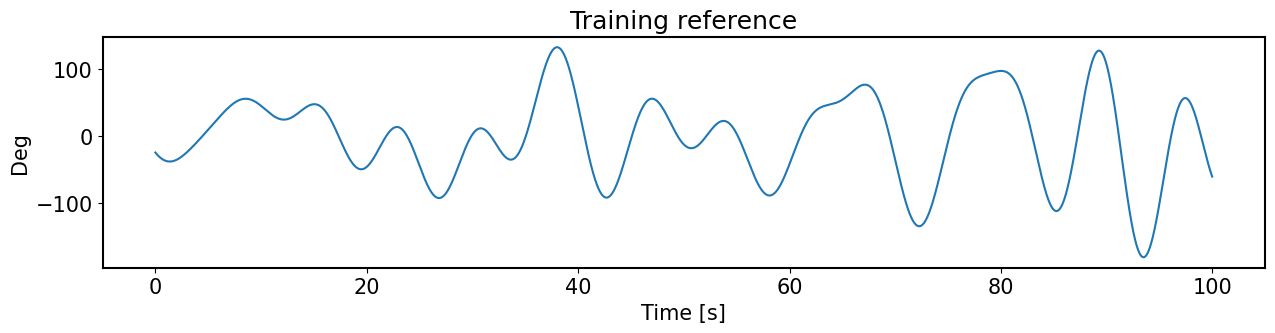

In [232]:
###############################
N = 10000
dt = 1e-2
pi = np.pi
nb_parts = 200
phi = rnd.uniform(low=-pi, high=pi, size=nb_parts)
f = rnd.uniform(low=.02, high=.15, size=nb_parts)*dt
A = rnd.uniform(low=-pi, high=pi, size=nb_parts)
###############################
time = np.arange(0,N,1)
t = np.arange(0,N*dt,dt)
pend1 = SimplePendulum(mass=1, length=1, time=t, X0=np.array([deg2rad(0),0]), dt=dt)
pend2 = SimplePendulum(mass=1, length=1, time=t, X0=np.array([deg2rad(60),0]), dt=dt)
###############################
x_train = 0
for i in range(nb_parts):
    x_train = x_train + A[i]*np.sin(2*pi*f[i]*time + phi[i])
    
x_train = x_train/max(max(x_train),-min(x_train))*pi
pend1.ref = x_train
###############################
fig, ax = plt.subplots(ncols=1, figsize=(15,3))
ax.set_title('Training reference')
ax.plot(t,rad2deg(x_train)), ax.set_xlabel('Time [s]'), ax.set_ylabel('Deg')
plt.savefig('Images/Midterm/Reference.png',dpi=800)

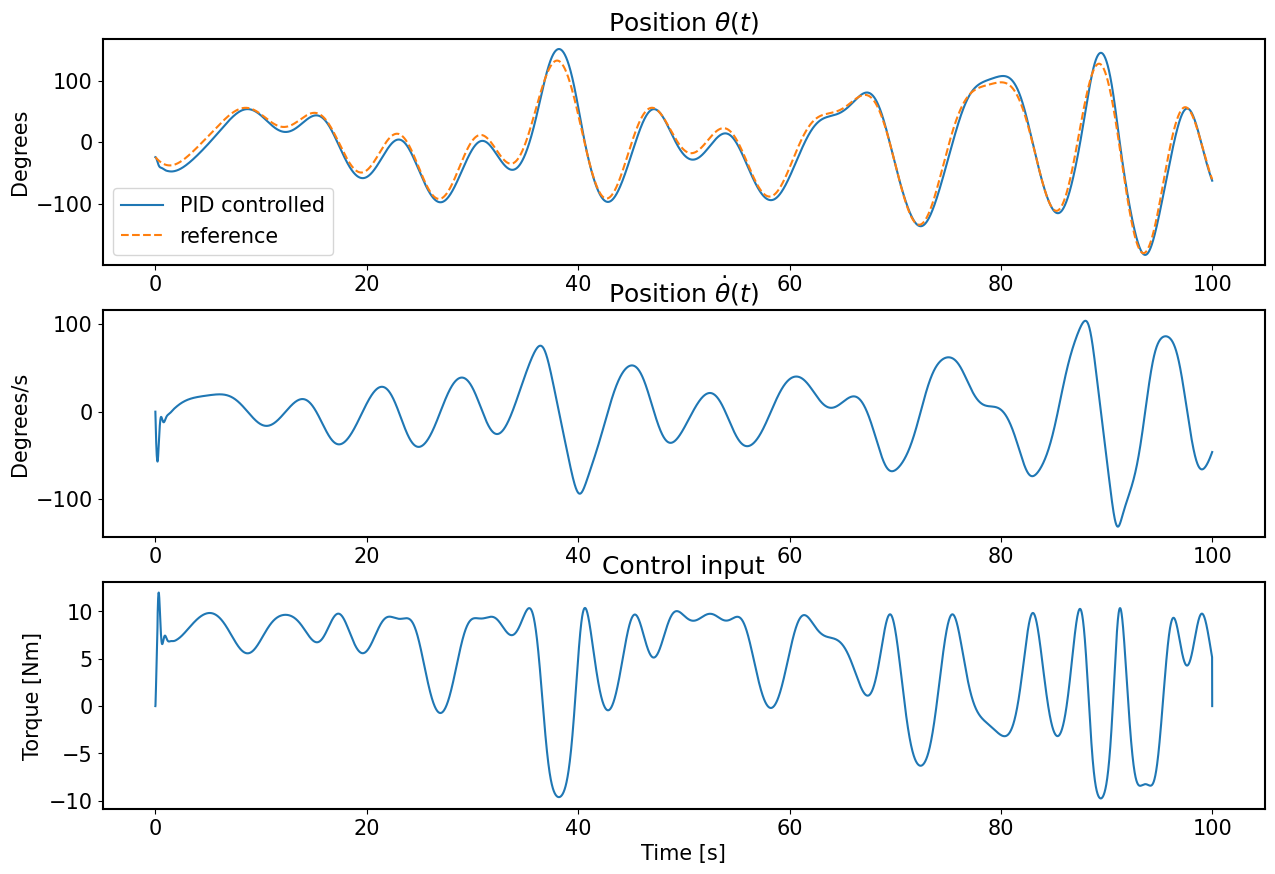

In [233]:
Kp, Ki, Kd = 50, 20, 5
pend1.U, pend2.U = np.zeros(shape=[N]), np.zeros(shape=[N])
pend1.X, pend2.X = np.zeros(shape=[2,N]), np.zeros(shape=[2,N])
# TRAINING ###################################
pend1.X[0,0] = pend1.ref[0]
for i in range(N-1):
    pend1.U[i] = PID(pend1.X, i, pend1.ref[i], Kp, Kd, Ki, pend1.dt, 20, limit=[-20,20])[0] 
    pend1.X[:,i+1] = RK4(pend1.dynamics, pend1.X[:,i], pend1.U[i], pend1.dt, type='controller-step-by-step')
# TESTING ####################################
# pend2.X[0,0] = pend2.ref[0]
# for i in range(N-1):
#     pend2.U[i] = PID(pend2.X[:,:], i, pend2.ref[i], Kp, Kd, Ki, pend2.dt, 20, limit=[-20,20])[0] 
#     pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step') + rnd.normal(0,.01,2)
    
fig, ax = plt.subplots(nrows=3, figsize=(15,10))
plt.rcParams['lines.linewidth'] = 1.5
ax[0].plot(t,rad2deg(pend1.X[0,:]),label='PID controlled'), ax[0].plot(t,rad2deg(pend1.ref),linestyle='dashed',label='reference'),ax[0].legend()
ax[0].set_ylabel('Degrees'), ax[0].set_title(r'Position $\theta(t)$')
ax[1].plot(t,rad2deg(pend1.X[1,:]))
ax[1].set_ylabel('Degrees/s'), ax[1].set_title(r'Position $\dot{\theta}(t)$')
ax[2].plot(pend1.T[:len(pend1.T)],pend1.U)
ax[2].set_title('Control input'), ax[2].set_xlabel('Time [s]'), ax[2].set_ylabel('Torque [Nm]')

plt.savefig('Images/Midterm/PID.png',dpi=800)

## Train model

In [259]:
# FIXED PARAMETERS #####################################
pend = pend1
Tau = np.array([4,5,7,9,10,12])
model1 = HAVOK(pend.X, pend.U)
# SWEEP THROUGH PARAMETERS #############################
Delay_spacing = np.arange(2,150,10)
Horizon = np.arange(20,np.int(.8*pend.N/(1+max(Delay_spacing))),10)
print('Max delay spacing : ',max(Delay_spacing),' Max horizon : ',max(Horizon))
residuals = np.empty(shape=[len(Tau),2,len(Delay_spacing),len(Horizon)])
traj_error = np.empty(shape=[len(Tau),2,len(Delay_spacing),len(Horizon)])
for t in range(len(Tau)):
    for i in range(len(Horizon)):
        for j in range(len(Delay_spacing)):
            model1.HANKEL(Horizon[i], delay_spacing=Delay_spacing[j])
            model1.SVD(Tau[t])
            model1.LS(Tau[t],rcond=0)
            model1.Simulate(pend.X[:,0],U_testing = pend.U)
            model1.TrajError(pend.X)

            residuals[t,:,j,i] = model1.residuals
            traj_error[t,:,j,i] = model1.traj_error
            if (traj_error[t,0,j,i] >= .5e3)or(np.isnan(traj_error[t,0,j,i])): traj_error[t,0,j,i] = .5e3
            if (traj_error[t,1,j,i] >= .5e3)or(np.isnan(traj_error[t,1,j,i])): traj_error[t,1,j,i] = .5e3

Max delay spacing :  142  Max horizon :  50


C:\Users\cedri\OneDrive\Documents\Mécanique - EPFL\Master III\Semester project\Software\My code\Subspace-learning-for-robot-application\LQR simulation\Utils\Functions.py:426: RuntimeWarning: overflow encountered in square
  self.traj_error = np.sqrt(np.sum(np.square(X - self.X_traj),axis=1))
C:\Users\cedri\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Min of trajectory error in position : ( 82 , 20 ) Value for pos. :  111.7679462402204 Value for vel. :  68.2493552381247 , delay =  4
Min of trajectory error in velocity : ( 82 , 20 ) Value for pos. :  111.7679462402204 Value for vel. :  68.2493552381247 , delay =  4
Min of residuals in position : ( 2 , 20 ) Value for pos. :  4.2224283334392536e-05 Value for vel. :  0.05457232928904978 , delay =  4
Min of residuals in velocity : ( 122 , 40 ) Value for pos. :  0.00319982994622146 Value for vel. :  0.00010073846689729406 , delay =  4
Min of trajectory error in position : ( 132 , 40 ) Value for pos. :  122.94809599544422 Value for vel. :  92.14088498271424 , delay =  5
Min of trajectory error in velocity : ( 82 , 20 ) Value for pos. :  176.5859216031633 Value for vel. :  71.27683235913348 , delay =  5
Min of residuals in position : ( 2 , 20 ) Value for pos. :  1.109764587798707e-06 Value for vel. :  0.0030334815736559047 , delay =  5
Min of residuals in velocity : ( 132 , 30 ) Value for p

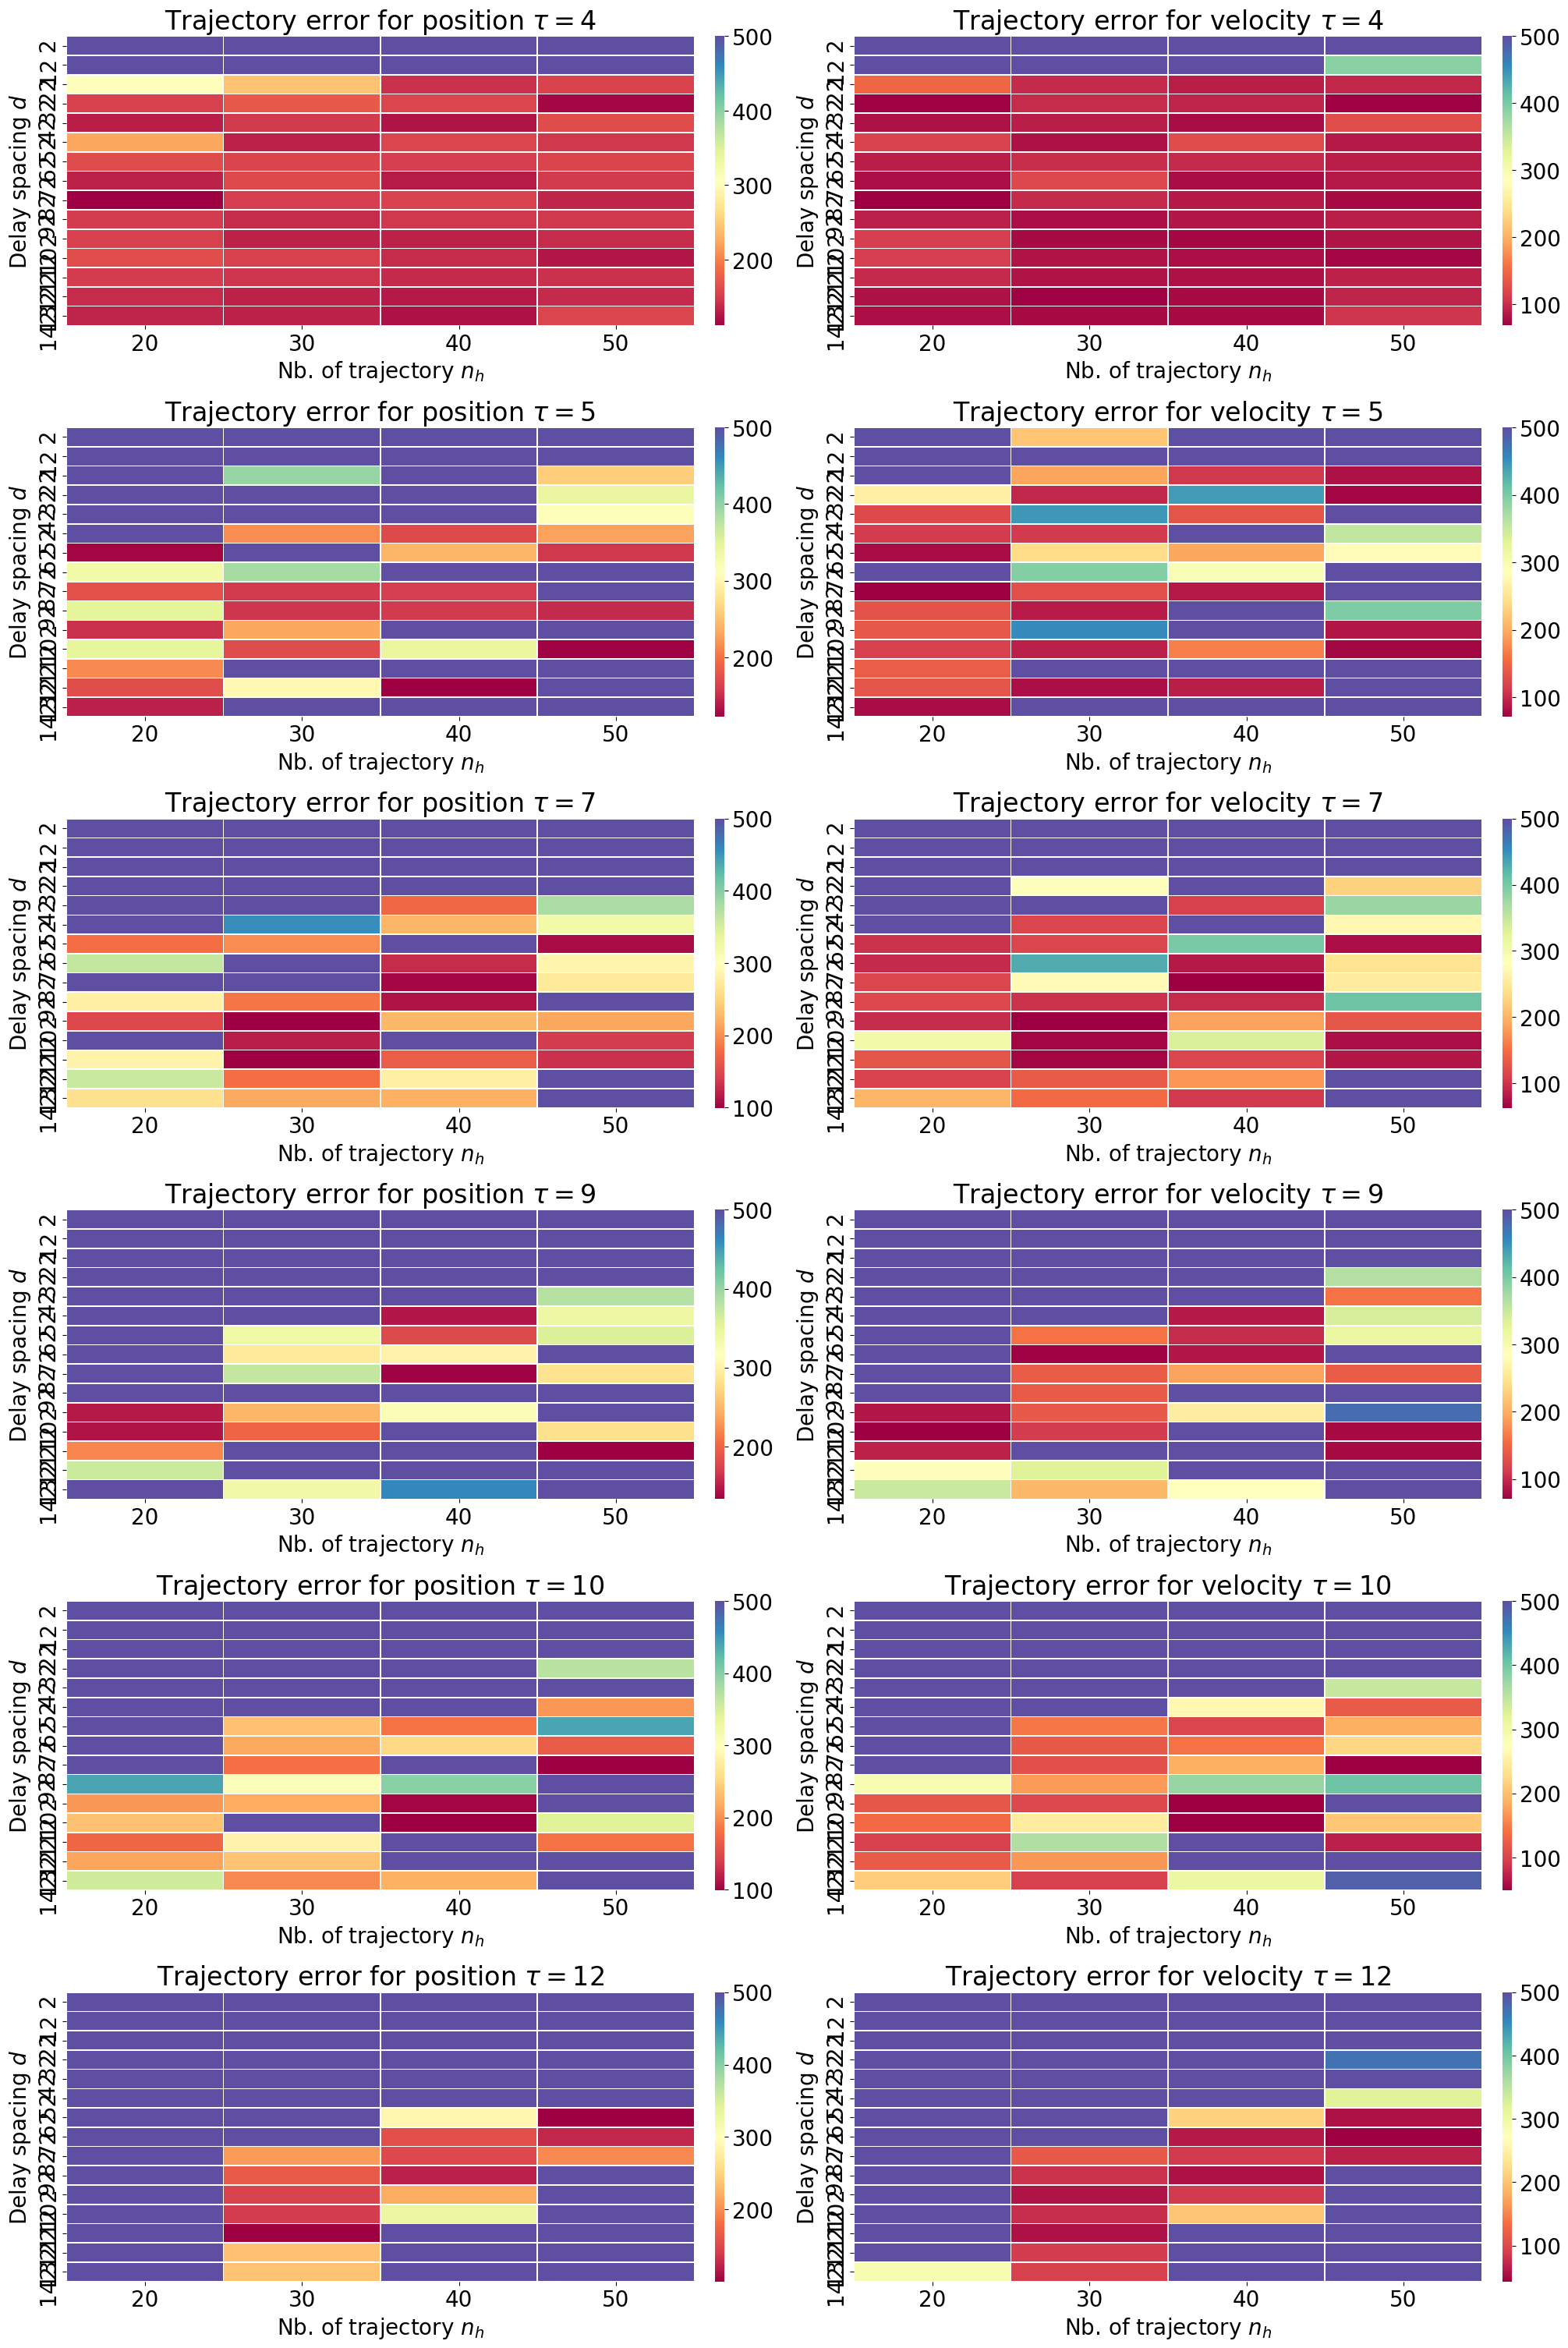

In [260]:
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(len(Tau),2, 
                       constrained_layout = True, figsize=(20,5*len(Tau)))

for t in range(len(Tau)):

    ax[t,0].set_title(r'Trajectory error for position $\tau = $'+str(Tau[t]))
    snb.heatmap(traj_error[t,0,:,:],cmap='Spectral',ax=ax[t,0],linewidths=.5)
    ax[t,0].set_xlabel(r'Nb. of trajectory $n_h$'), ax[t,0].set_ylabel(r'Delay spacing $d$')
    ax[t,0].set_xticks(np.arange(0.5,len(Horizon),1)), ax[t,0].set_yticks(np.arange(0.5,len(Delay_spacing),1))
    ax[t,0].set_xticklabels(Horizon), ax[t,0].set_yticklabels(Delay_spacing)

    ax[t,1].set_title(r'Trajectory error for velocity $\tau = $'+str(Tau[t]))
    snb.heatmap(traj_error[t,1,:,:],cmap='Spectral',ax=ax[t,1],linewidths=.5)
    ax[t,1].set_xlabel(r'Nb. of trajectory $n_h$'), ax[t,1].set_ylabel(r'Delay spacing $d$')
    ax[t,1].set_xticks(np.arange(0.5,len(Horizon),1)), ax[t,1].set_yticks(np.arange(0.5,len(Delay_spacing),1))
    ax[t,1].set_xticklabels(Horizon), ax[t,1].set_yticklabels(Delay_spacing)
    
    index = np.argmin(traj_error[t,0,:,:])
    pos_y, pos_x = index//len(Horizon), index%len(Horizon)
    print('Min of trajectory error in position : (',Delay_spacing[pos_y],',',Horizon[pos_x],')','Value for pos. : ',traj_error[t,0,pos_y,pos_x],
          'Value for vel. : ',traj_error[t,1,pos_y,pos_x],', delay = ',Tau[t])

    index = np.argmin(traj_error[t,1,:,:])
    pos_y, pos_x = index//len(Horizon), index%len(Horizon)
    print('Min of trajectory error in velocity : (',Delay_spacing[pos_y],',',Horizon[pos_x],')','Value for pos. : ',traj_error[t,0,pos_y,pos_x],
          'Value for vel. : ',traj_error[t,1,pos_y,pos_x],', delay = ',Tau[t])
    
    index = np.argmin(residuals[t,0,:,:])
    pos_y, pos_x = index//len(Horizon), index%len(Horizon)
    print('Min of residuals in position : (',Delay_spacing[pos_y],',',Horizon[pos_x],')','Value for pos. : ',residuals[t,0,pos_y,pos_x],
          'Value for vel. : ',residuals[t,1,pos_y,pos_x],', delay = ',Tau[t])

    index = np.argmin(residuals[t,1,:,:])
    pos_y, pos_x = index//len(Horizon), index%len(Horizon)
    print('Min of residuals in velocity : (',Delay_spacing[pos_y],',',Horizon[pos_x],')','Value for pos. : ',residuals[t,0,pos_y,pos_x],
          'Value for vel. : ',residuals[t,1,pos_y,pos_x],', delay = ',Tau[t])

In [88]:
# FIXED PARAMETERS #####################################
pend = pend1
Tau_2 = 7
model1 = HAVOK(pend.X, pend.U)
# SWEEP THROUGH PARAMETERS #############################
best_spacing, best_horizon = 72, 50
search_range = 10
resolution = 2
Delay_spacing_2 = np.arange(best_spacing-search_range,best_spacing+search_range,resolution)
Horizon_2 = np.arange(best_horizon-search_range,best_horizon+search_range,resolution)
traj_error_2 = np.empty(shape=[2,len(Delay_spacing_2),len(Horizon_2)])
residuals_2 = np.empty(shape=[2,len(Delay_spacing_2),len(Horizon_2)])
for i in range(len(Horizon_2)):
    for j in range(len(Delay_spacing_2)):
        model1.HANKEL(Horizon_2[i], delay_spacing=Delay_spacing_2[j])
        model1.SVD(Tau_2)
        model1.LS(Tau_2,rcond=0)
        model1.Simulate(pend.X[:,0],U_testing = pend.U)
        model1.TrajError(pend.X)
        
        traj_error_2[:,j,i] = model1.traj_error
        residuals_2[:,j,i] = model1.residuals
        if traj_error_2[0,j,i] >= .5e3: traj_error_2[0,j,i] = .5e3
        if traj_error_2[1,j,i] >= .5e3: traj_error_2[1,j,i] = .5e3

Min of trajectory error in position : ( 62 , 56 ) Value for pos. :  69.98525901497028 Value for vel. :  56.33985963865547
Min of trajectory error in velocity : ( 76 , 46 ) Value for pos. :  71.90052488685835 Value for vel. :  54.32183994872662
Min of trajectory error in position : ( 76 , 58 ) Value for pos. :  0.006596505320114222 Value for vel. :  0.018189851084775346
Min of trajectory error in velocity : ( 76 , 40 ) Value for pos. :  0.19574070981394864 Value for vel. :  9.905751178099684e-05


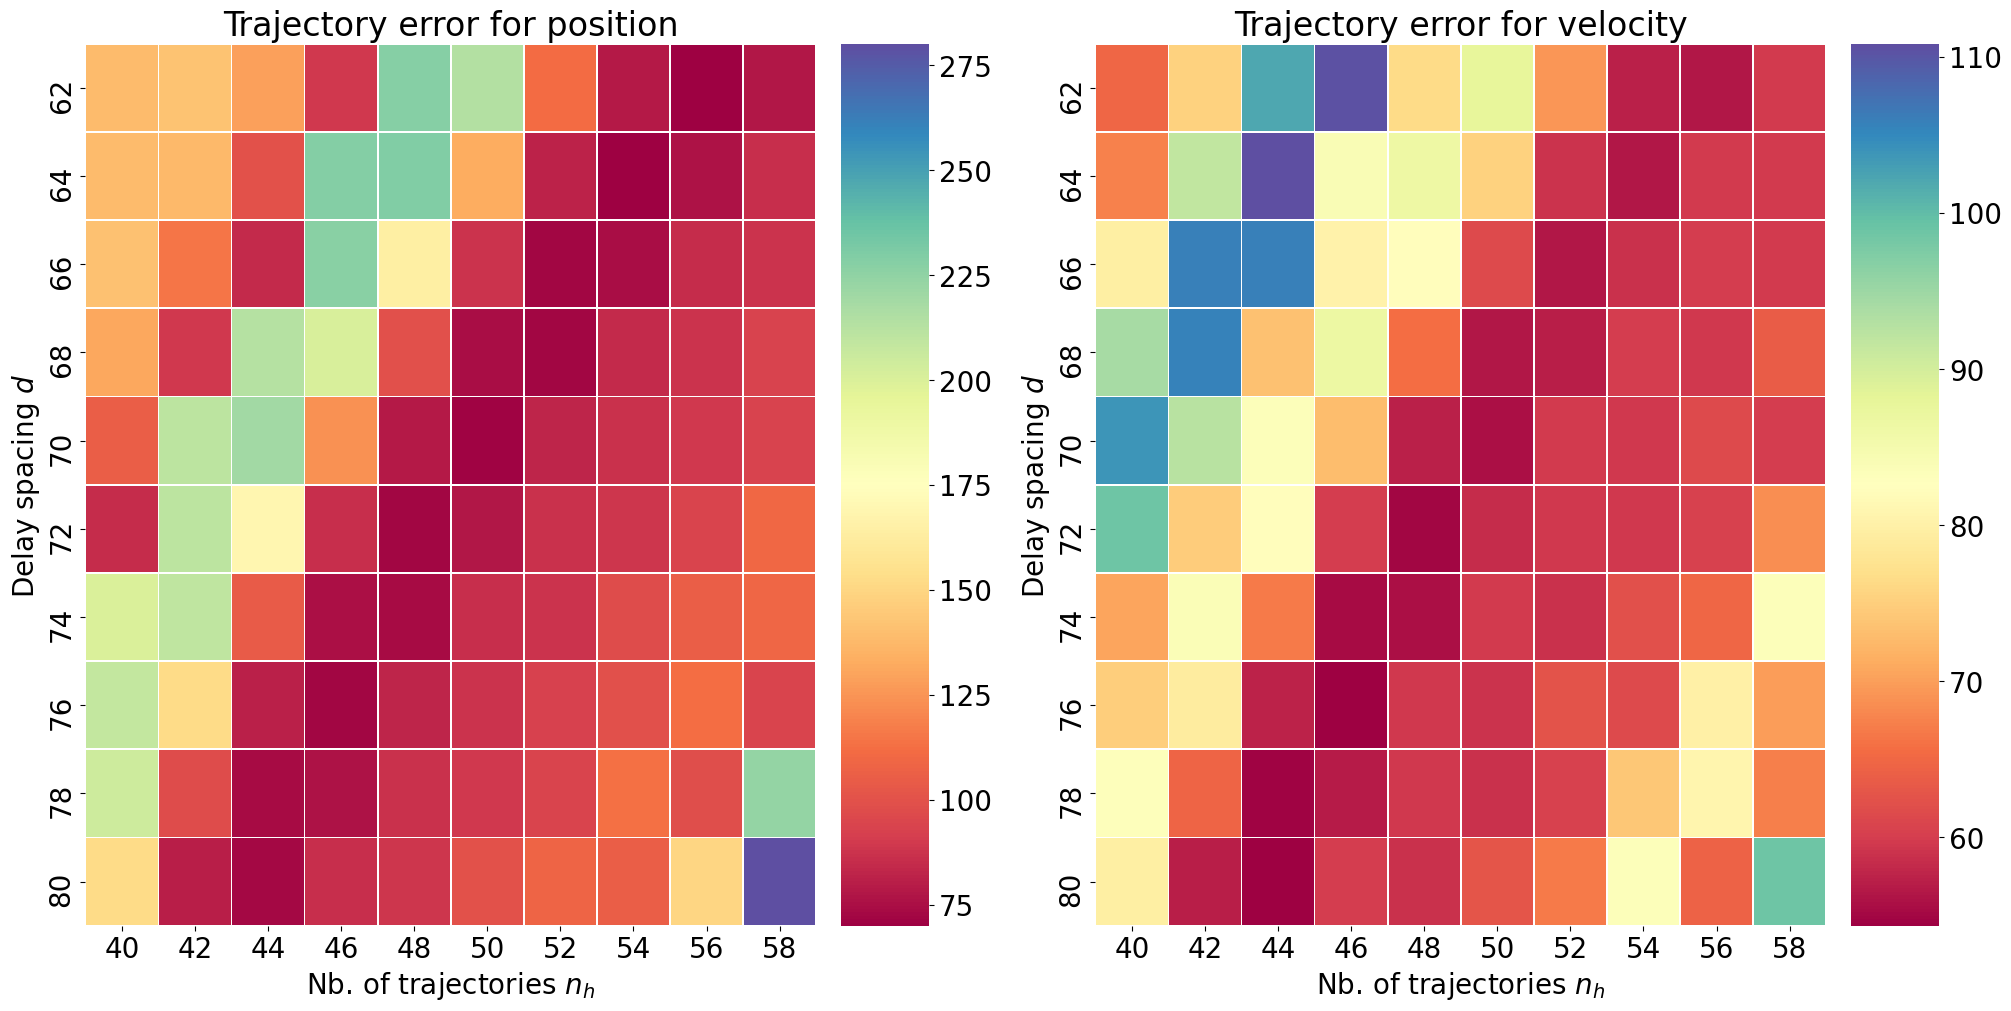

In [89]:
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,2,
                       constrained_layout = True, figsize=(20,10))
ax[0].set_title('Trajectory error for position')
snb.heatmap(traj_error_2[0,:,:],cmap='Spectral',ax=ax[0],linewidths=.5)
ax[0].set_xlabel(r'Nb. of trajectories $n_h$'), ax[0].set_ylabel(r'Delay spacing $d$')
ax[0].set_xticks(np.arange(0.5,len(Horizon_2),1)), ax[0].set_yticks(np.arange(0.5,len(Delay_spacing_2),1))
ax[0].set_xticklabels(Horizon_2), ax[0].set_yticklabels(Delay_spacing_2)
ax[1].set_title('Trajectory error for velocity')
snb.heatmap(traj_error_2[1,:,:],cmap='Spectral',ax=ax[1],linewidths=.5)
ax[1].set_xlabel(r'Nb. of trajectories $n_h$'), ax[1].set_ylabel(r'Delay spacing $d$')
ax[1].set_xticks(np.arange(0.5,len(Horizon_2),1)), ax[1].set_yticks(np.arange(0.5,len(Delay_spacing_2),1))
ax[1].set_xticklabels(Horizon_2), ax[1].set_yticklabels(Delay_spacing_2)
                                                                  
index = np.argmin(traj_error_2[0,:,:])
pos_y, pos_x = index//len(Horizon_2), index%len(Horizon_2)
print('Min of trajectory error in position : (',Delay_spacing_2[pos_y],',',Horizon_2[pos_x],')','Value for pos. : ',traj_error_2[0,pos_y,pos_x],
      'Value for vel. : ',traj_error_2[1,pos_y,pos_x])

index = np.argmin(traj_error_2[1,:,:])
pos_y, pos_x = index//len(Horizon_2), index%len(Horizon_2)
print('Min of trajectory error in velocity : (',Delay_spacing_2[pos_y],',',Horizon_2[pos_x],')','Value for pos. : ',traj_error_2[0,pos_y,pos_x],
      'Value for vel. : ',traj_error_2[1,pos_y,pos_x])

index = np.argmin(residuals_2[0,:,:])
pos_y, pos_x = index//len(Horizon_2), index%len(Horizon_2)
print('Min of trajectory error in position : (',Delay_spacing_2[pos_y],',',Horizon_2[pos_x],')','Value for pos. : ',residuals_2[0,pos_y,pos_x],
      'Value for vel. : ',residuals_2[1,pos_y,pos_x])

index = np.argmin(residuals_2[1,:,:])
pos_y, pos_x = index//len(Horizon_2), index%len(Horizon_2)
print('Min of trajectory error in velocity : (',Delay_spacing_2[pos_y],',',Horizon_2[pos_x],')','Value for pos. : ',residuals_2[0,pos_y,pos_x],
      'Value for vel. : ',residuals_2[1,pos_y,pos_x])

## Final model

In [268]:
tau = 10
# Training
pend=pend1
model1 = HAVOK(pend.X, pend.U)
horizon = 50
model1.HANKEL(horizon, delay_spacing=82)
model1.SVD(tau)
model1.LS(tau,rcond=0)
model1.Simulate(pend.X[:,0],U_testing = pend.U)
model1.TrajError(pend.X)
print(model1.H.shape)
print(model1.traj_error)
print(model1.residuals)
print(model1.B.shape)

(100, 5850)
[99.26133 49.35198]
[0.00194 0.00048]
(10, 10)


(Text(0, 0.5, 'Degrees'), Text(0, 0.5, 'Degrees/sec'))

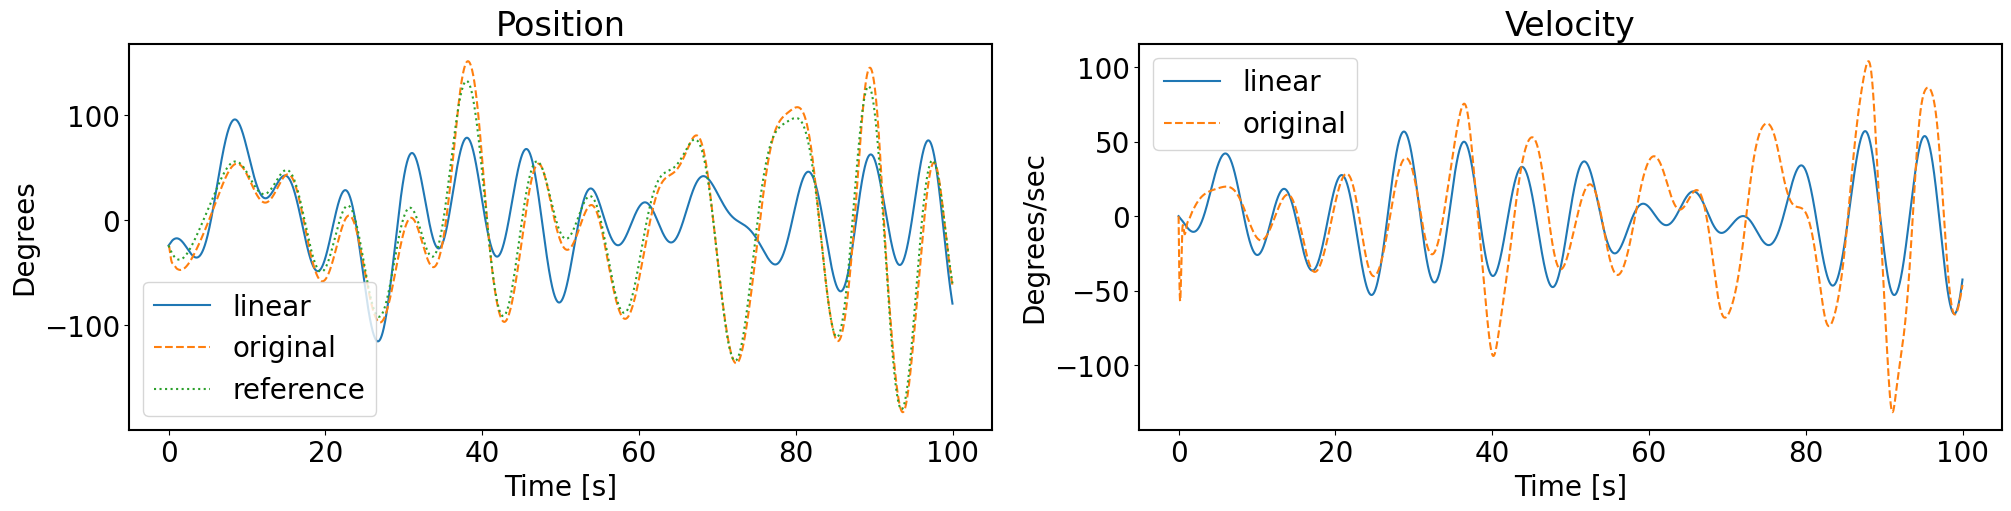

In [269]:
pend = pend1
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(ncols=2, 
                       constrained_layout = True, figsize=(20,5))
ax[0].plot(pend.T,rad2deg(model1.X_traj[0,:]),label='linear'), ax[1].plot(pend.T,rad2deg(model1.X_traj[1,:]),label='linear')
ax[0].plot(pend.T,rad2deg(pend.X[0,:]),label='original',linestyle='dashed'), ax[1].plot(pend.T,rad2deg(pend.X[1,:]),label='original',linestyle='dashed')
ax[0].plot(pend.T,rad2deg(np.array(pend.ref)),linestyle='dotted',label='reference'), ax[0].legend(), ax[1].legend()
ax[0].set_title('Position'), ax[1].set_title('Velocity')
ax[0].set_xlabel('Time [s]'), ax[1].set_xlabel('Time [s]')
ax[0].set_ylabel('Degrees'), ax[1].set_ylabel('Degrees/sec')

# plt.savefig('Images/Midterm/Training.png',dpi=800)

## Testing

In [270]:
###############################
dt = 1e-2
pi = np.pi
nb_parts = 200
phi = rnd.uniform(low=-pi, high=pi, size=nb_parts)
f = rnd.uniform(low=.02, high=.15, size=nb_parts)*dt
A = rnd.uniform(low=-pi, high=pi, size=nb_parts)
###############################
time = np.arange(0,pend1.N,1)
t = np.arange(0,pend1.N*dt,dt)
pend2 = SimplePendulum(mass=1, length=1, time=t, X0=np.array([deg2rad(60),0]), dt=dt)
###############################
x_test = 0
for i in range(nb_parts):
    x_test = x_test + A[i]*np.sin(2*pi*f[i]*time + phi[i])
    
x_test = x_test/max(max(x_test),-min(x_test))*pi
pend2.ref = x_test
###############################
Kp, Ki, Kd = 50, 20, 5
pend2.X[0,0] = pend2.ref[0]
###############################
for i in range(pend2.N-1):
    pend2.U[i] = PID(pend2.X, i, pend2.ref[i], Kp, Kd, Ki, pend2.dt, 20, limit=[-20,20])[0] 
    pend2.X[:,i+1] = RK4(pend2.dynamics, pend2.X[:,i], pend2.U[i], pend2.dt, type='controller-step-by-step')

(100, 5850)
[194.25594 137.88676]


([<matplotlib.lines.Line2D at 0x1ab9c2afb50>],
 <matplotlib.legend.Legend at 0x1ab9c2afe80>)

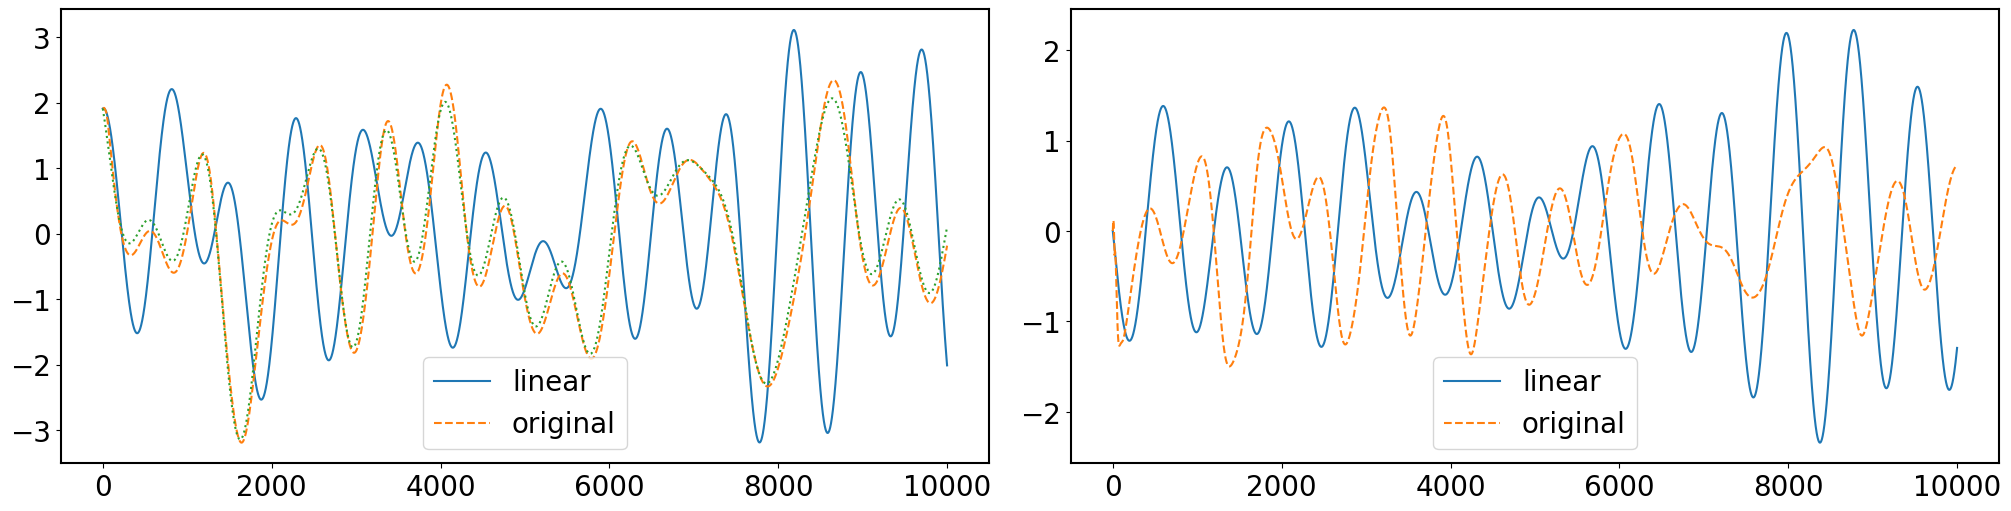

In [271]:
pend = pend2
model1.Simulate(pend.X[:,0],U_testing = pend.U)
model1.TrajError(pend.X)
print(model1.H.shape)
print(model1.traj_error)
##########################################
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(ncols=2, 
                       constrained_layout = True, figsize=(20,5))
ax[0].plot(model1.X_traj[0,:],label='linear'), ax[1].plot(model1.X_traj[1,:],label='linear')
# ax[0].plot(X_train[0,:N-1],label='original',linestyle='dashed'), ax[1].plot(X_train[1,:N-1],label='original',linestyle='dashed')
ax[0].plot(pend.X[0,:],label='original',linestyle='dashed'), ax[1].plot(pend.X[1,:],label='original',linestyle='dashed')
ax[0].plot(np.array(pend.ref),linestyle='dotted'), ax[0].legend(), ax[1].legend()

## LQR planning

(9999, 10)


(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(901.2166691812039, 0.5, 'Subspace coordinate $r$'))

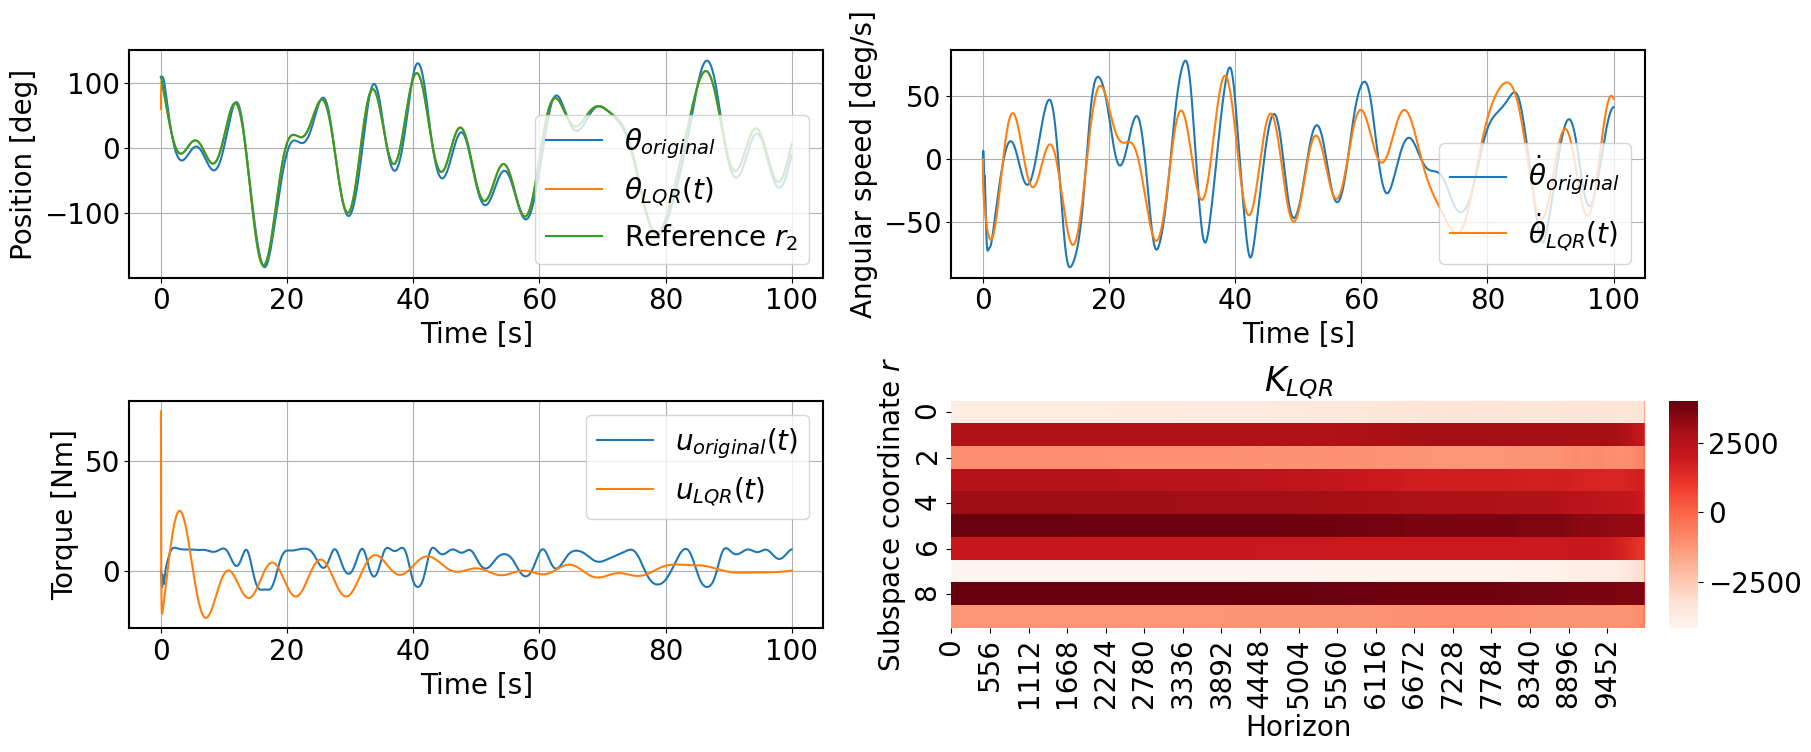

In [272]:
pend=pend2
model1.Simulate(pend.X0, U_testing=pend.U)
model1.ConstructLQR(x_std=1e6, u_std=1e-1, dt=pend.dt, ref=pend.ref)
model1.LQR_simulate(pend.X0)

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(pend.X[0,:]), label=r'$\theta_{original}$')
ax[0,0].plot(pend.T, rad2deg(model1.LQR_X[:,0]), label=r"$\theta_{LQR} (t)$")
ax[0,0].plot(pend.T, rad2deg(np.array(pend.ref)), label="Reference $r_2$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(pend.X[1,:]), label=r'$\dot{\theta}_{original}$')
ax[0,1].plot(pend.T, rad2deg(model1.LQR_X[:,1]), label=r"$\dot{\theta}_{LQR} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()
print(model1.LQR_U[0,:,:].shape)
ax[1,0].plot(pend.T[:model1.N-1], pend.U, label='$u_{original}(t)$')
ax[1,0].plot(pend.T[:model1.N-1], (model1.LQR_U[0,:,:].T)[0], label='$u_{LQR}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

## LQR

(10,)
LQR cost :  174717464395.31982
LQR cost :  252110787011.4679


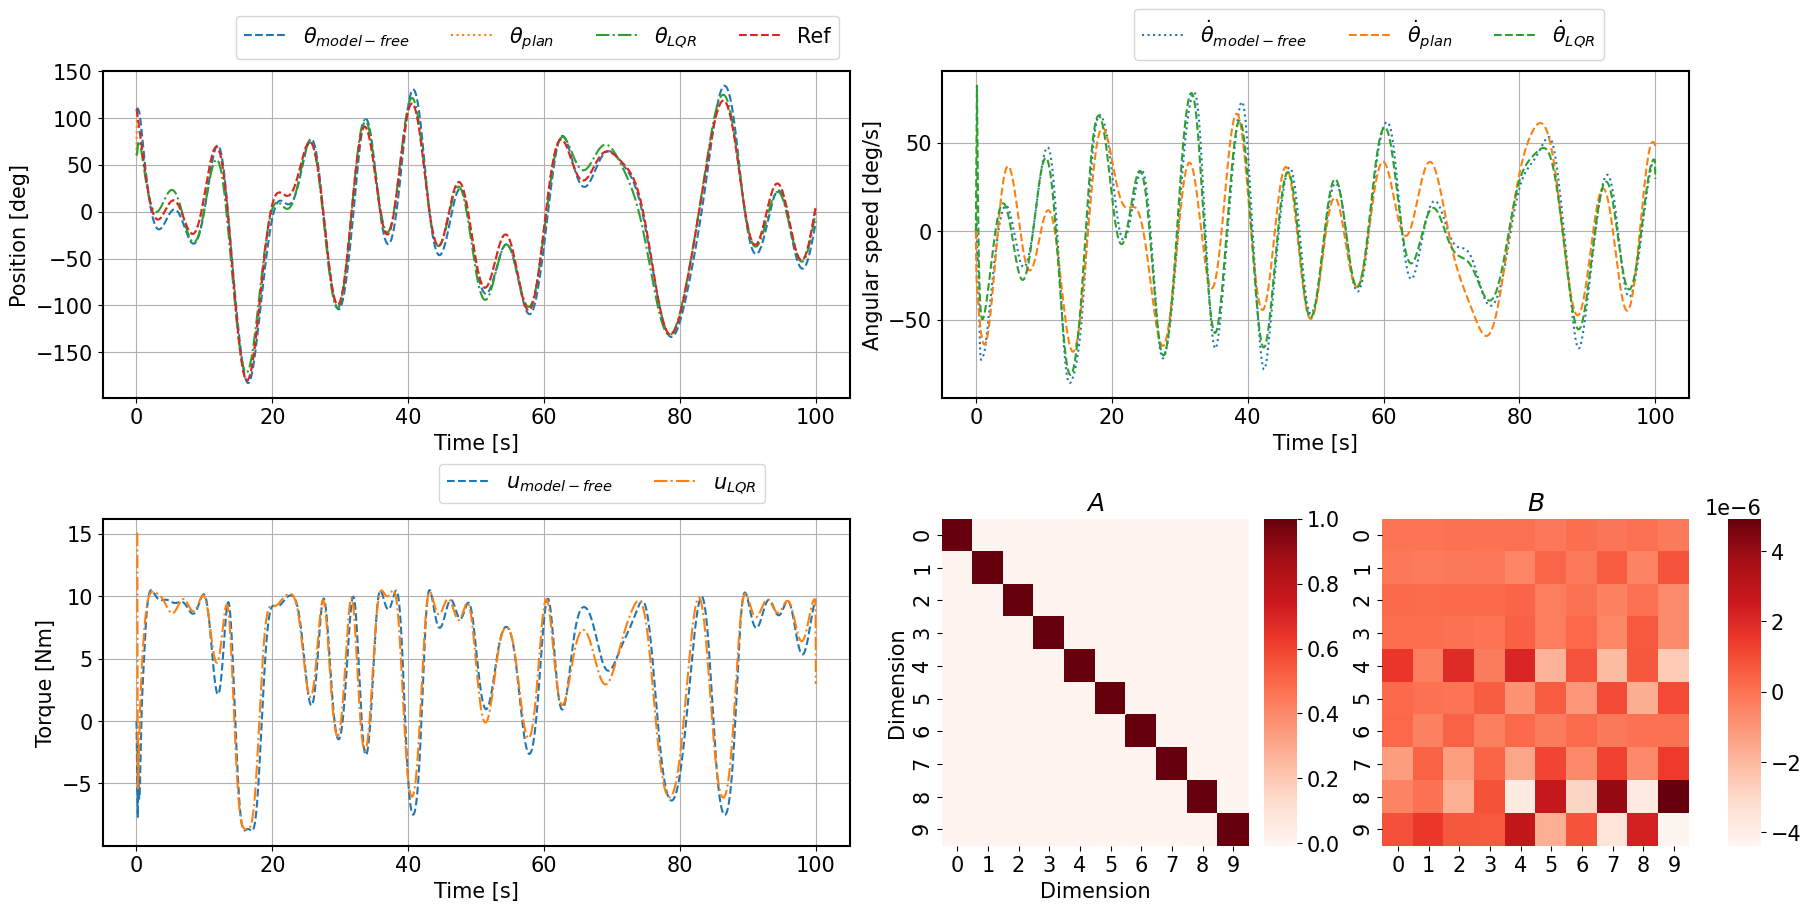

In [274]:
pend = pend2
X0 = pend.X0
Xc, Yc = np.zeros(shape=[model1.nb_S,model1.N]), np.zeros(shape=[model1.tau,model1.N])
Uc = np.empty(shape=[model1.N-1])
Ky = np.array(model1.LQR.K)[:,0,:]
Kx = Ky@pinv(model1.C)
t_interval = pend.dt

# Initial condition
Xc[:,0] = X0
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
Y0 = pinv(model1.C)@X0
Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,0] = Y0

f = lambda theta, u : pend.dynamics(theta, u)
u_max = [-15,15] # Limiting contol input size
print((model1.P.T@model1.LQR.get_command(Yc[:,i],i)).shape)
# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(model1.N-1):
    
    Uc[i] = (model1.LQR.get_command(Yc[:,i],i))[0]
    if Uc[i] >= u_max[1]: Uc[i] = u_max[1]
    if Uc[i] <= u_max[0]: Uc[i] = u_max[0]
    
    Xc[:,i+1]= RK4(f, Xc[:,i], Uc[i], t_interval, type='controller-step-by-step')
    Yc[:,i+1] = pinv(model1.C)@Xc[:,i+1]
    
print('LQR cost : ',model1.LQR_cost(Xc, Uc, pend.ref))
print('LQR cost : ',model1.LQR_cost(pend2.X, pend2.U, pend.ref))
    
# Plot
plt.rcParams['font.size'] = 15
fig = plt.figure(constrained_layout = True, figsize=(18,9))

gs = fig.add_gridspec(8, 8)

ax00 = fig.add_subplot(gs[0:4,0:4])
ax01 = fig.add_subplot(gs[0:4,4:8])
ax10 = fig.add_subplot(gs[4:8,0:4])
ax11_0 = fig.add_subplot(gs[4:8,4:6])
ax11_1 = fig.add_subplot(gs[4:8,6:8])

ax00.plot(pend.T, rad2deg(pend.X[0,:]), linestyle='dashed', label=r'$\theta_{model-free}$')
ax00.plot(pend.T, rad2deg(model1.LQR_X[:,0]), linestyle=':', label=r'$\theta_{plan}$')
ax00.plot(pend.T, rad2deg(Xc[0,:]), linestyle='dashdot', label=r"$\theta_{LQR}$")
ax00.plot(pend.T, rad2deg(np.array(pend.ref)), linestyle='dashed', label='Ref')
ax00.set_xlabel('Time [s]'), ax00.set_ylabel('Position [deg]')
ax00.grid()
ax00.legend(bbox_to_anchor=(1, 1.2),ncol=5)

ax01.plot(pend.T, rad2deg(pend.X[1,:]), linestyle='dotted', label=r'$\dot{\theta}_{model-free}$')
ax01.plot(pend.T, rad2deg(model1.LQR_X[:,1]), linestyle='dashed', label=r"$\dot{\theta}_{plan}$")
ax01.plot(pend.T, rad2deg(Xc[1,:]), linestyle='dashed', label=r"$\dot{\theta}_{LQR}$")
ax01.set_xlabel('Time [s]'), ax01.set_ylabel('Angular speed [deg/s]')
ax01.grid()
ax01.legend(bbox_to_anchor=(.9, 1.22),ncol=4)

ax10.plot(pend.T[:model1.N-1], pend.U, linestyle='dashed', label='$u_{model-free}$')
# ax10.plot(pend.T[:model1.N-1], model1.LQR_U[0,:,0], linestyle='dotted', label='$u_{plan}$')
ax10.plot(pend.T[:model1.N-1], Uc, linestyle='dashdot', label='$u_{LQR}$')
ax10.set_xlabel('Time [s]'), ax10.set_ylabel('Torque [Nm]')
ax10.grid()
ax10.legend(bbox_to_anchor=(.9, 1.2),ncol=3)

ax11_0.set_title('$A$')
figA = snb.heatmap(model1.A,cmap='Reds',ax=ax11_0)
ax11_0.set_ylabel('Dimension'), ax11_0.set_xlabel('Dimension')

ax11_1.set_title('$B$')
figA = snb.heatmap(model1.B,cmap='Reds')

# fig.savefig('Images/Pend_HAVOK_trajectories_sine2.svg',format='svg',dpi=800)
# fig.savefig('Images/Midterm/summary.png',dpi=800)

## Comparing different LQR trajectories

## Pendulum swing-up

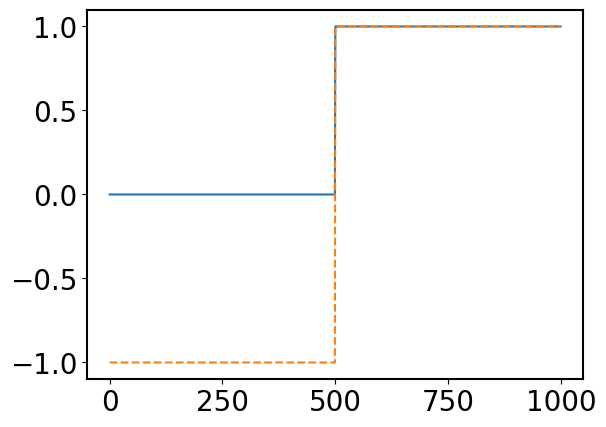

In [292]:
freq = .05
dt = 1e-2
period = 1/freq/dt
pend3 = SimplePendulum(mass=1, length=1, time=np.arange(0,10,dt), X0=np.array([deg2rad(120),0]), dt=dt)
pend = pend3
pend.ref = np.zeros([2,pend.N])
# pend.ref[0,:] = sineReference(pend.N, pend.dt, period, 180, -90)
pend.ref[0,:] = np.hstack((deg2rad(-90)*np.ones(np.int(pend.N/2)),deg2rad(90)*np.ones(np.int(pend.N/2))))
precision1, precision2 = np.zeros(shape=[2,pend.N]), np.zeros(shape=[2,pend.N])
nb = np.int(pend.N/(period/2))

x_std = 1e6
# precision[0,np.int(period/4)::np.int(period/2)] = x_std*np.ones(nb)
precision1[0,np.int(pend.N/2):pend.N] = np.ones(np.int(pend.N/2))*x_std
precision2[0,np.int(pend.N/2):pend.N] = np.ones(np.int(pend.N/2))*x_std
# precision2[0,:pend.N] = np.ones(np.int(pend.N))*x_std
plt.plot(precision1[0,:]/x_std)
plt.plot(pend.ref[0,:]/deg2rad(90),linestyle='dashed')

(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(880.5768176960553, 0.5, 'Subspace coordinate $r$'))

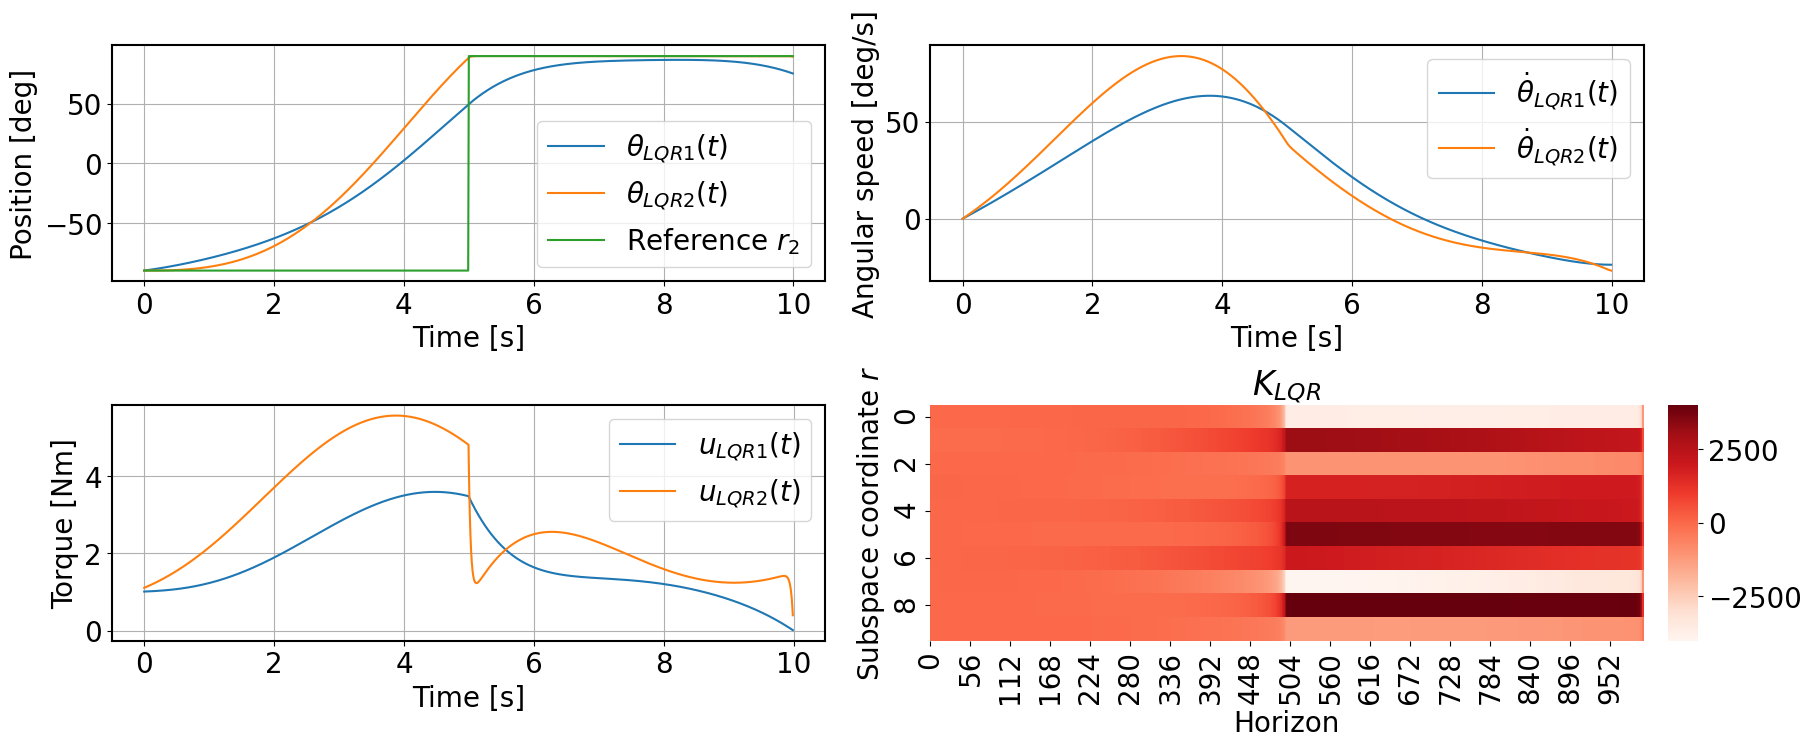

In [297]:
u_std = 30e-1
model1.ConstructLQR(x_std=x_std, u_std=u_std, dt=pend.dt, ref=pend.ref.T, horizon=pend.N, custom_trajectory=precision1)
model1.LQR_simulate(np.array([deg2rad(-90),0]))
LQR1_X, LQR1_U, LQR1 = model1.LQR_X, model1.LQR_U, model1.LQR
u_std = 1e-2
model1.ConstructLQR(x_std=x_std, u_std=u_std, dt=pend.dt, ref=pend.ref.T, horizon=pend.N, custom_trajectory=precision2)
model1.LQR_simulate(np.array([deg2rad(-90),0]))
LQR2_X, LQR2_U, LQR2 = model1.LQR_X, model1.LQR_U, model1.LQR

# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(LQR1_X[:,0]), label=r"$\theta_{LQR1} (t)$")
ax[0,0].plot(pend.T, rad2deg(LQR2_X[:,0]), label=r"$\theta_{LQR2} (t)$")
ax[0,0].plot(pend.T, rad2deg(pend.ref[0,:]), label="Reference $r_2$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(LQR1_X[:,1]), label=r"$\dot{\theta}_{LQR1} (t)$")
ax[0,1].plot(pend.T, rad2deg(LQR2_X[:,1]), label=r"$\dot{\theta}_{LQR2} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:pend.N-1], LQR1_U[0,:,0], label='$u_{LQR1}(t)$')
ax[1,0].plot(pend.T[:pend.N-1], LQR2_U[0,:,0], label='$u_{LQR2}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

(Text(0.5, 32.167000000000016, 'Horizon'),
 Text(901.561923039882, 0.5, 'Subspace coordinate $r$'))

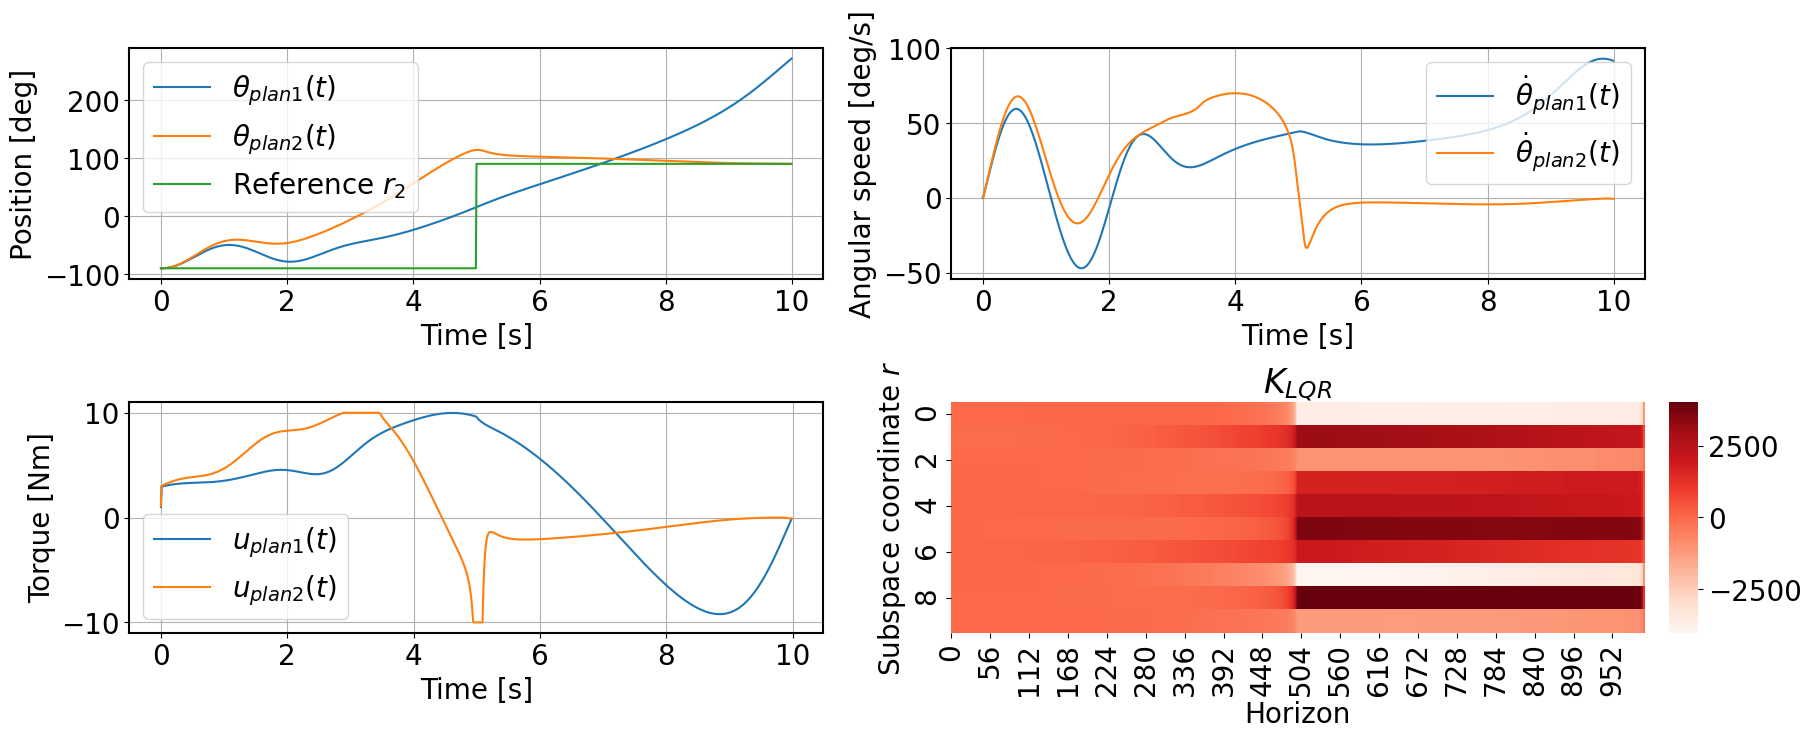

In [298]:
X0 = np.array([deg2rad(-90),0])
Xc, Yc = np.zeros(shape=[2,model1.nb_S,pend.N]), np.zeros(shape=[2,model1.tau,pend.N])
Uc = np.empty(shape=[2,pend.N-1])
Ky = np.array(model1.LQR.K)[:,0,:]
Kx = Ky@pinv(model1.C)
t_interval = pend.dt
LQR = np.array([LQR1,LQR2])

# Initial condition
Xc[:,:,0] = X0
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
Y0 = pinv(model1.C)@X0
Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
Yc[:,:,0] = Y0

f = lambda theta, u : pend.dynamics(theta, u)
u_max = [-10,10]

# Simulate the closed-loop trajectory for the non-linear dynamics
for i in range(pend.N-1):
    
    for j in range(2):
        Uc[j,i] = LQR[j].get_command(Yc[j,:,i],i)[0]
        
        if Uc[j,i] >= u_max[1]: Uc[j,i] = u_max[1]
        if Uc[j,i] <= u_max[0]: Uc[j,i] = u_max[0]

        Xc[j,:,i+1]= RK4(f, Xc[j,:,i], Uc[j,i], t_interval, type='controller-step-by-step')
        Yc[j,:,i+1] = pinv(model1.C)@Xc[j,:,i+1]
    
# # Evaluate LQR costs
# cost_roll = model1.LQR_cost(model1.LQR_X.T,model1.LQR_U[0,:,0],pend.ref[0,:],horizon=pend.N)
# cost_plan = model1.LQR_cost(Xc,Uc,pend.ref[0,:],horizon=pend.N)
# print('Rollout cost is ',cost_roll/cost_plan*100,' [%] of planning cost')
    
# Plot
plt.rcParams['font.size'] = 20
fig,ax = plt.subplots(2, 2, constrained_layout = True, figsize=(18,7))

ax[0,0].plot(pend.T, rad2deg(Xc[0,0,:]), label=r"$\theta_{plan1} (t)$")
ax[0,0].plot(pend.T, rad2deg(Xc[1,0,:]), label=r"$\theta_{plan2} (t)$")
ax[0,0].plot(pend.T, rad2deg(pend.ref[0,:]), label="Reference $r_2$")
ax[0,0].set_xlabel('Time [s]'), ax[0,0].set_ylabel('Position [deg]')
ax[0,0].grid()
ax[0,0].legend()

ax[0,1].plot(pend.T, rad2deg(Xc[0,1,:]), label=r"$\dot{\theta}_{plan1} (t)$")
ax[0,1].plot(pend.T, rad2deg(Xc[1,1,:]), label=r"$\dot{\theta}_{plan2} (t)$")
ax[0,1].set_xlabel('Time [s]'), ax[0,1].set_ylabel('Angular speed [deg/s]')
ax[0,1].grid()
ax[0,1].legend()

ax[1,0].plot(pend.T[:pend.N-1], Uc[0,:], label='$u_{plan1}(t)$')
ax[1,0].plot(pend.T[:pend.N-1], Uc[1,:], label='$u_{plan2}(t)$')
ax[1,0].set_xlabel('Time [s]'), ax[1,0].set_ylabel('Torque [Nm]')
ax[1,0].grid()
ax[1,0].legend()

ax[1,1].set_title('$K_{LQR}$')
figA = snb.heatmap(np.array(model1.LQR._K)[:,0,:].T,cmap='Reds')
ax[1,1].set_xlabel('Horizon'), ax[1,1].set_ylabel(r'Subspace coordinate $r$')

## Robustness to IC variation

In [318]:
pend=pend2
ic_variations = np.array([-.25,-.2,-.15,-.1,-.05,-.01,0,.01,.05,.1,.15,.2,.25]) + 1
# ic_variations = np.array([1])
# ic_variations = np.array([.2]) + 1
X0_original = rad2deg(pend.ref[0])
M = len(ic_variations)
original_cost = np.empty(shape=M)
LQR_cost = np.empty(shape=M)
xQx = np.empty(shape=[2,M])
uRu = np.empty(shape=[2,M])
Uc = np.empty(shape=[model1.N-1])

# Initial condition
Xc, Yc = np.zeros(shape=[model1.nb_S,model1.N]), np.zeros(shape=[model1.tau,model1.N])
N = np.eye(model1.tau) - pinv(model1.C) @ model1.C
f = lambda theta, u : pend.dynamics(theta, u)

u_max = [-10,10]

for i in range(M):
    # New IC
    pend.X0 = np.array([deg2rad(X0_original*ic_variations[i]),0])
    
    # LQR training
    Xc[:,0] = pend.X0
    Y0 = pinv(model1.C)@X0
    Y0 = Y0 + N@(model1.Y[:,0] - Y0) # Nullspace projection into subspace 
    Yc[:,0] = Y0
    model1.ConstructLQR(x_std=1e6, u_std=1e-1, dt=pend.dt, ref=pend.ref)
    pend.X[:,0] = pend.X0
    
    for j in range(model1.N-1):
    
        # Original simulation
        pend.U[j] = PID(pend.X, j, pend.ref[j], 50, 5, 20, pend.dt, 20, limit=[-10,10])[0]
        pend.X[:,j+1] = RK4(pend.dynamics, pend.X[:,j], pend.U[j], pend.dt, type='controller-step-by-step')

        Uc[j] = model1.LQR.get_command(Yc[:,j],j)[0]
        if Uc[j] >= u_max[1]: Uc[j] = u_max[1]
        if Uc[j] <= u_max[0]: Uc[j] = u_max[0]

        # LQR planning
        Xc[:,j+1]= RK4(f, Xc[:,j], Uc[j], t_interval, type='controller-step-by-step')
        Yc[:,j+1] = pinv(model1.C)@Xc[:,j+1]
    
    # LQR cost saving
    original_cost[i] = model1.LQR_cost(pend.X, pend.U, pend.ref)
    xQx[0,i], uRu[0,i] = model1.xQx, model1.uRu
    LQR_cost[i] = model1.LQR_cost(Xc, Uc, pend.ref)
    xQx[1,i], uRu[1,i] = model1.xQx, model1.uRu
    
print(np.multiply(LQR_cost,np.reciprocal(original_cost)))
print(LQR_cost)
print(original_cost)
print(xQx)
print(uRu)

# plt.figure()
# plt.plot(pend.X[0,:]), plt.plot(Xc[0,:])
# plt.figure()
# plt.plot(pend.U), plt.plot(Uc)

[0.63139 0.63093 0.63011 0.62839 0.62654 0.62573 0.62569 0.62573 0.62697
 0.63189 0.6395  0.65428 0.67744]
[1.70150e+11 1.68962e+11 1.68089e+11 1.67399e+11 1.66874e+11 1.66732e+11
 1.66754e+11 1.66803e+11 1.67339e+11 1.69046e+11 1.72501e+11 1.78713e+11
 1.89410e+11]
[2.69485e+11 2.67797e+11 2.66761e+11 2.66393e+11 2.66341e+11 2.66459e+11
 2.66511e+11 2.66572e+11 2.66902e+11 2.67526e+11 2.69743e+11 2.73145e+11
 2.79596e+11]
[[2.69485e+11 2.67797e+11 2.66761e+11 2.66393e+11 2.66341e+11 2.66459e+11
  2.66511e+11 2.66572e+11 2.66902e+11 2.67526e+11 2.69743e+11 2.73145e+11
  2.79596e+11]
 [1.70150e+11 1.68962e+11 1.68089e+11 1.67399e+11 1.66874e+11 1.66732e+11
  1.66754e+11 1.66803e+11 1.67339e+11 1.69046e+11 1.72501e+11 1.78713e+11
  1.89410e+11]]
[[51621.58249 51506.83708 51399.52226 51301.18363 51226.32947 51200.35118
  51198.56139 51198.65244 51217.81415 51282.98525 51313.47235 51420.96005
  51583.03503]
 [50801.4818  50769.79322 50768.76563 50827.91548 50900.17795 50964.69951
  50981.4

In [195]:
print(LQR_cost)

[nan nan nan nan nan nan nan nan nan nan nan nan nan]


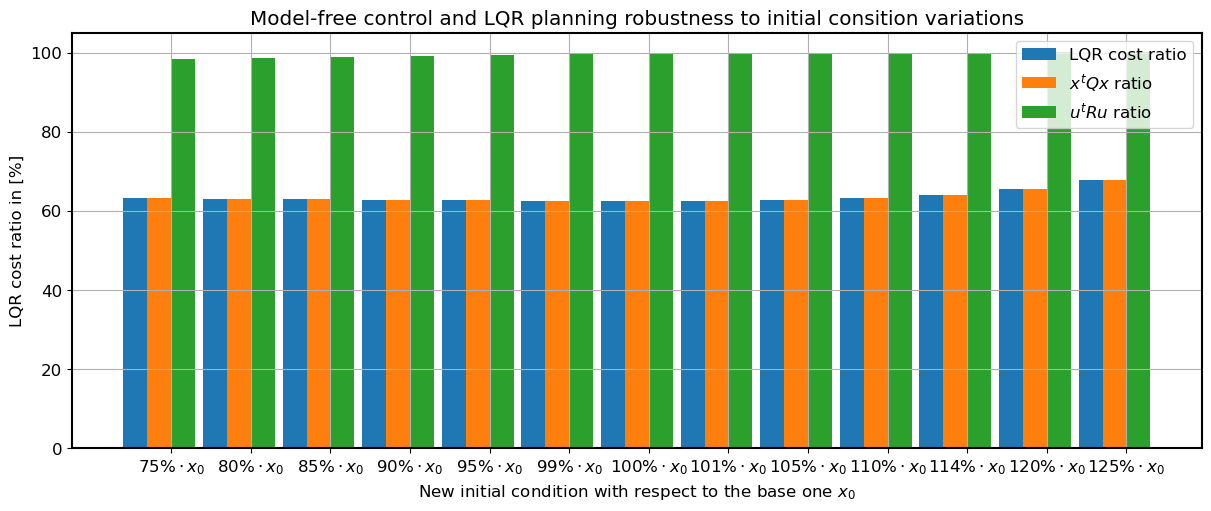

In [321]:
plt.rcParams['font.size'] = 12
x_label = [(str(np.int(x*100))+r'$\%\cdot x_0$') for x in ic_variations.tolist()]
barwidth = .3
bar1 = np.arange(len(ic_variations))
bar2 = [x + barwidth for x in bar1]
bar3 = [x + 2*barwidth for x in bar1]

cost_ratio = np.multiply(LQR_cost,np.reciprocal(original_cost))
xQx_ratio = np.multiply(xQx[1,:],np.reciprocal(xQx[0,:]))
uRu_ratio = np.multiply(uRu[1,:],np.reciprocal(uRu[0,:]))

fig = plt.figure(constrained_layout = True, figsize=(12,5))
plt.bar(bar1,100*cost_ratio,width = barwidth,label='LQR cost ratio')
plt.bar(bar2,100*xQx_ratio,width = barwidth,label=r'$x^tQx$ ratio')
plt.bar(bar3,100*uRu_ratio,width = barwidth,label=r'$u^tRu$ ratio')

plt.xticks([x + 3*barwidth/2 for x in bar1], x_label)
plt.ylabel('LQR cost ratio in [%]'), plt.xlabel('New initial condition with respect to the base one $x_0$')
plt.title('Model-free control and LQR planning robustness to initial consition variations')
plt.legend(), plt.grid()

fig.savefig('Images/Midterm/Pend_HAVOK_boxplot.png',format='png',dpi=800)